## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [147]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.tokens import DocBin
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import scattertext as st
import pickle
import polars as pl
import pyarrow
import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

'en_US.UTF-8'

In [ ]:
# load data 
# ----------
congress_tweets = pd.read_csv("../../data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
congress_tweets.head()

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [ ]:
def pre_model(text):
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    return punc_free

def post_model(doc):
    stop_words = STOP_WORDS.union({"qt","rt","amp"})
    spacy_words = [token.lemma_ for token in doc if not token.like_url]
    
    spacy_words = [word for word in spacy_words if not (word.startswith('http') or word.startswith("RT") or word.startswith("QT"))]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [ ]:
pre_model_data = congress_tweets['text'].map(pre_model)

In [ ]:
docs = list(nlp.pipe(pre_model_data,n_process=4, batch_size=4000))

In [ ]:
# doc_bin = DocBin(docs=docs)
# doc_bin.to_disk("./data.spacy")
doc_bin = DocBin().from_disk("./data.spacy")
new_docs = list(doc_bin.get_docs(nlp.vocab))

In [ ]:
post_model_data = [post_model(doc) for doc in new_docs]
congress_tweets['tokens'] = post_model_data
congress_tweets['joined_tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))

In [ ]:
# congress_tweets.head()
# congress_tweets.to_pickle('cleanedData.pkl')
congress_tweets = pd.read_pickle("cleanedData.pkl") 

In [ ]:
congress_tweets['party'].unique()

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

In [ ]:
wordcloud_text = ' '.join(congress_tweets['joined_tokens'])
wordcloud = WordCloud(background_color="white",random_state=111).generate(wordcloud_text)

In [ ]:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### EDA 2

In [ ]:

scatter_tweets = congress_tweets.copy() 
scatter_tweets['doc'] = new_docs
corpus = st.CorpusFromParsedDocuments(scatter_tweets, category_col="party", parsed_col="doc").build()

In [ ]:
html = st.produce_scattertext_explorer(corpus,
                                       category='Democrat',
                                       category_name='Democratic',
                                       not_category_name='Republican',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5,
                                       metadata=congress_tweets['screen_name'])

In [ ]:
open("PoliticalTweets.html", 'wb').write(html.encode('utf-8'))

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [ ]:
congress_tweets['polarity'] = congress_tweets['joined_tokens'].map(lambda x: TextBlob(x).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['joined_tokens'].map(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
congress_tweets.to_pickle('sentimentData.pkl')
congress_tweets = pd.read_pickle("sentimentData.pkl") 
tweets = pl.from_pandas(congress_tweets)
tweets = tweets.filter((pl.col('party') == "Republican") | (pl.col("party") == "Democrat"))
tweets.head()

In [ ]:
two_sen = tweets.filter(pl.col("name_wikipedia").is_in(["Ted Cruz", "Maxine Waters"])).select("name_wikipedia","subjectivity","polarity","tweet_id")
sns.scatterplot(
   two_sen,
    x="subjectivity",
    y="polarity",
    hue="name_wikipedia",
    alpha=.3
)
plt.show()


In [ ]:
sns.kdeplot(two_sen,
            x="polarity",
            hue="name_wikipedia",
            )
plt.show()
sns.kdeplot(two_sen,
            x="subjectivity",
            hue="name_wikipedia"
            )
plt.show()

/Users/erawn/Computational-Social-Science-Training-Program/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


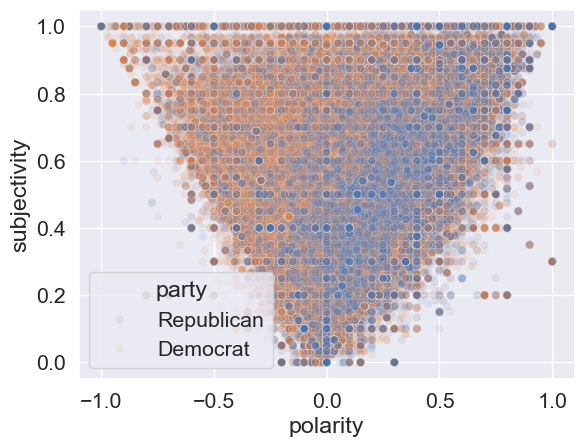

In [155]:
sns.scatterplot(tweets.select(["tweet_id","party","polarity","subjectivity"]),
            x="polarity",
            y="subjectivity",
            hue="party",
            alpha=.1
            )
plt.show()

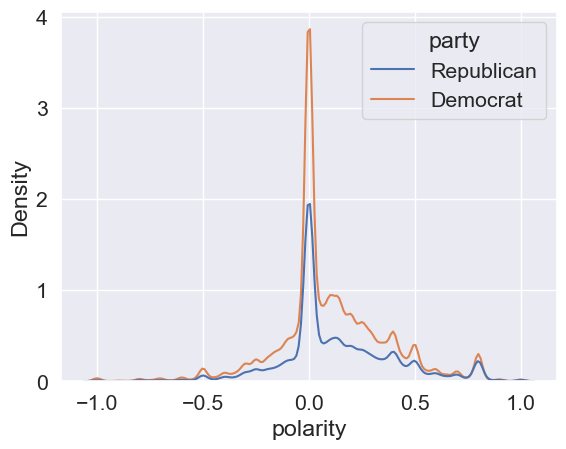

In [154]:
sns.kdeplot(tweets.select(["tweet_id","party","polarity","subjectivity"]),
            x="polarity",
            hue="party",
            )
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Bag-of-words or Tf-idf

In [ ]:
tf = TfidfVectorizer()
token_list = pl.Series(tweets.select('joined_tokens')).to_list()

In [ ]:
# Frequency Based featurization
tfidf_matrix = tf.fit_transform(token_list)

In [ ]:
def print_top_words(model, feature_names, n_top_words):   # define function and parameters
    for topic_idx, topic in enumerate(model.components_): # iterate over each topic 
        print("\nTopic #{}:".format(topic_idx))           # print topic index
        print(" ".join([feature_names[i]                  # print topics
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [ ]:
lda = LatentDirichletAllocation(n_components=10,
                                max_iter=1,
                                random_state=0).fit(tfidf_matrix)
tf_feature_names = tf.get_feature_names_out()

# apply function to print top 20 words
print_top_words(lda,                # model 
                tf_feature_names,   # feature names 
                20)    

In [ ]:
topic_dist = lda.transform(tfidf_matrix)

In [ ]:
topic_dist_df = pl.from_numpy(topic_dist)
topic_dist_df

### Engineered Text Features

In [ ]:
engineered_features = tweets.with_columns(
    word_count= (pl.col('tokens').list.len()),
    length=(pl.col('joined_tokens').str.len_chars())
    ).select(["word_count","length","polarity","subjectivity"])

### Word Embedding

In [ ]:
tokens_np:list = tweets.select('tokens').to_series().to_list()

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True) 
model = gensim.models.Word2Vec(tokens_np,    # specify data - sentences
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000, # sample size 
                               workers = 1)  

In [ ]:
model.save("word2vec.model")
model = gensim.models.Word2Vec.load("word2vec.model")

In [ ]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc_vecs = [word for word in doc if word in model.wv.index_to_key]
    try:
        if(len(doc_vecs) > 0):
            items = word2vec_model.wv.__getitem__(doc_vecs)
            mean = numpy.mean(items, axis=0)
            return mean
        return None
    except:
        print("ERROR")
        print(doc)
        print(doc_vecs)
        print(items)
       

In [ ]:
# embedding based featurization
doc_embeddings = [document_vector(model,token_list) for token_list in tokens_np]

In [ ]:
with open('doc_embeddings.pkl', 'wb') as file: 
    pickle.dump(doc_embeddings, file) 

with open('doc_embeddings.pkl', 'rb') as file:
    doc_embeddings  = pickle.load(file)

In [ ]:

cleaned_doc_embeddings = [numpy.zeros(100) if emb is None else emb for emb in doc_embeddings ]
doc_embeddings = numpy.array(cleaned_doc_embeddings)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
dataframes = [engineered_features,topic_dist_df,doc_embeddings]
techniques = ["Engineered Features", "LDA Topics", "Word2Vec"]

target_labels = ["Republican/Democrat","Senator/Representative"]
target_cat_labels = [["Democrat","Republican"],["Senator", "Representative"]]

In [125]:

party_np = tweets.select(pl.col('party')).to_series().to_numpy()
party_np[party_np == "Republican"] = 1
party_np[party_np == "Democrat"] = 0

position_np = tweets.select(pl.col('position')).to_series().to_numpy()
position_np[position_np == "Rep"] = 1
position_np[position_np == "Sen"] = 0

targets = [party_np.astype(int),position_np.astype(int)]

# lb_style = LabelBinarizer()
# print(position_np[0:50])
# t = lb_style.fit_transform(position_np)
t = targets[1]
t

array([1, 1, 1, ..., 1, 1, 0])

In [126]:
def logisticRegressionBatch(dataframes, techniques,targets,target_labels, target_cat_labels):
    for dataframe, technique in zip(dataframes, techniques):
        for target, target_label, target_cat_label in zip(targets,target_labels, target_cat_labels):
            X_train, X_test, y_train, y_test = train_test_split(dataframe,   
                                                        target,
                                                        train_size = .80,
                                                        test_size=0.20,
                                                        random_state = 125)
            logit_reg = LogisticRegression()
            logit_model = logit_reg.fit(X_train,
                                        y_train.ravel())
            
            y_pred = logit_model.predict(X_test)

            cf_matrix = confusion_matrix(y_test,y_pred,normalize = 'true')
            cf_df = pl.from_numpy(cf_matrix)
            cf_df.columns = [target_cat_label[0], target_cat_label[1]]
            plt.figure(figsize = (10,7)) # set figure size specifications
            sns.set(font_scale=1.4)      # set label size
            sns.heatmap(cf_df,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')

            plt.title(technique + " with " + target_label)
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.show()

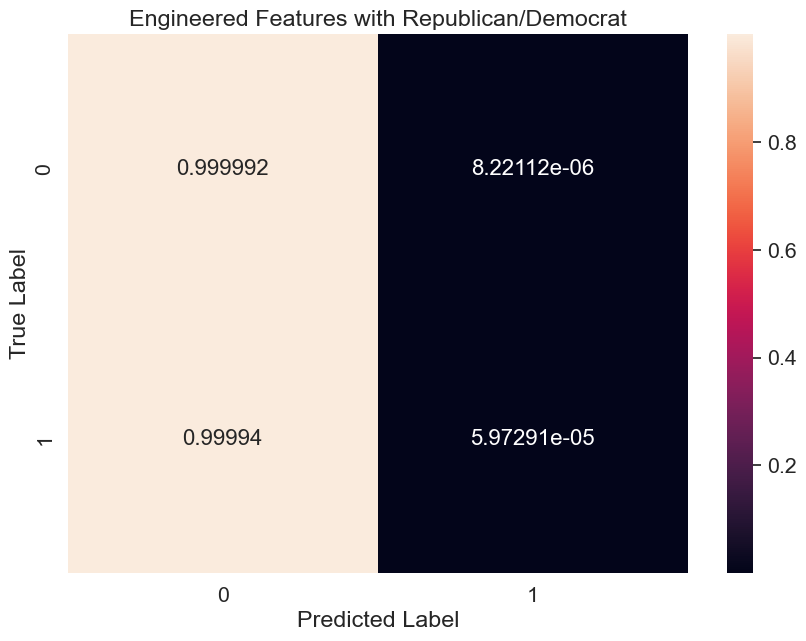

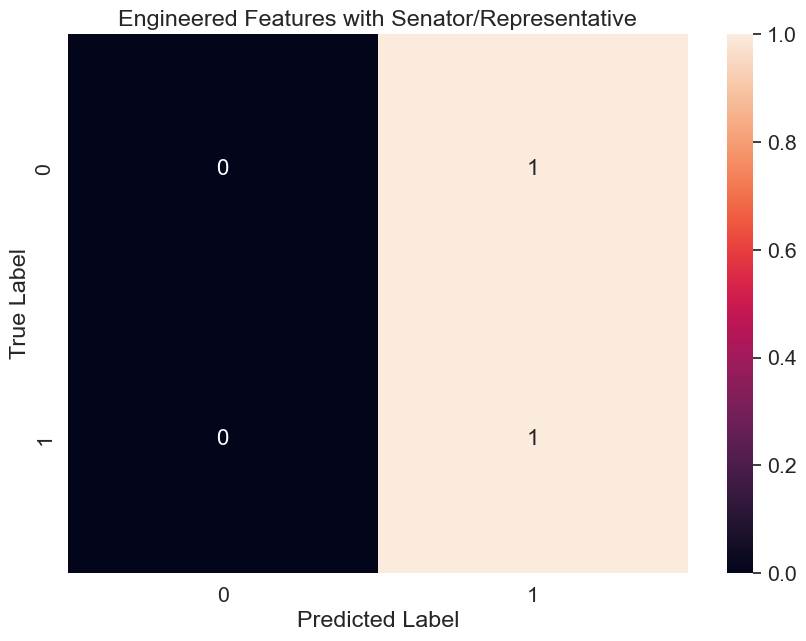

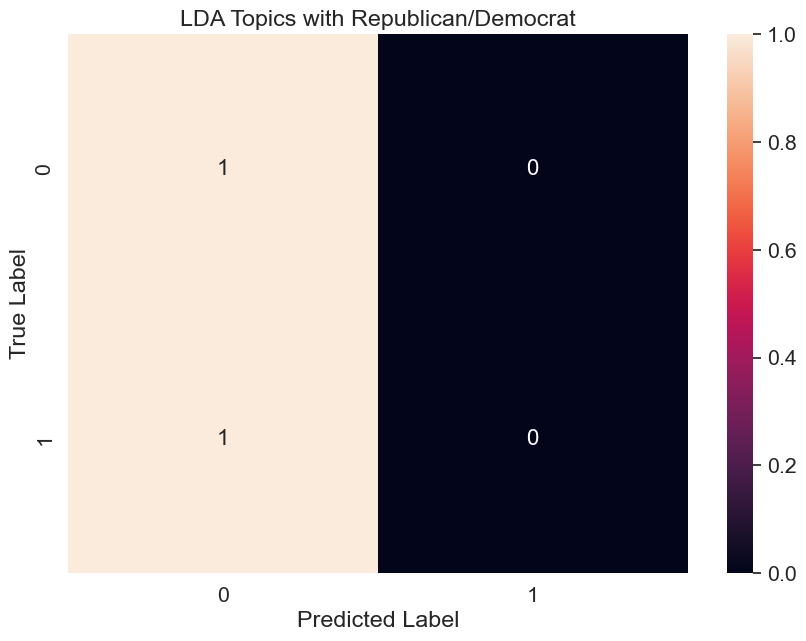

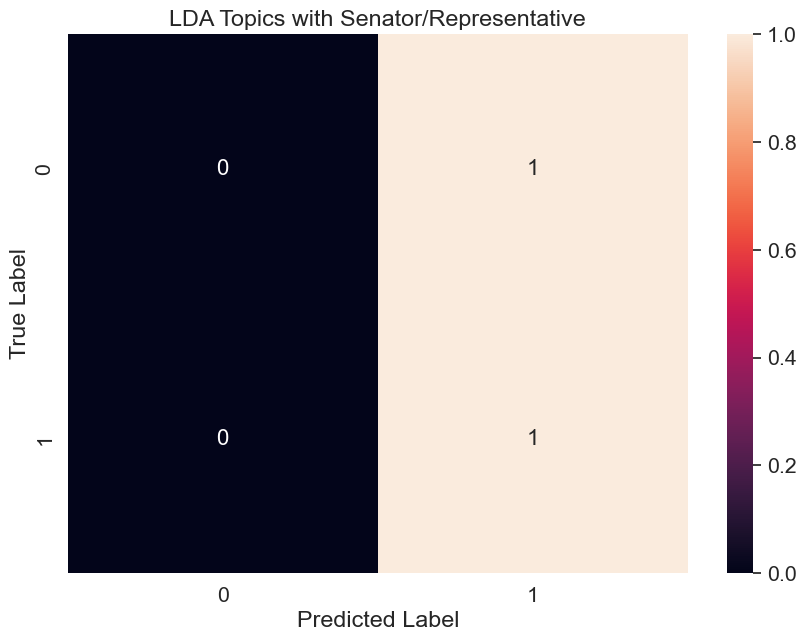

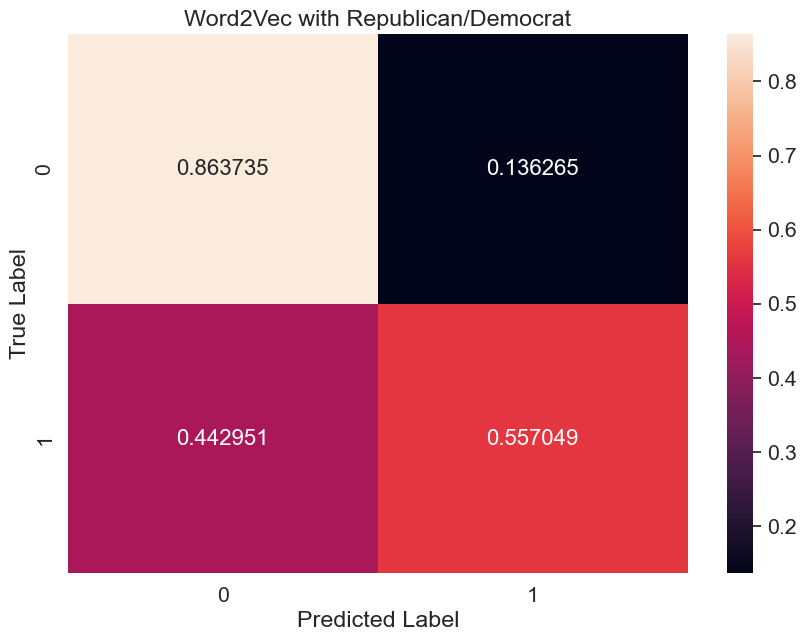

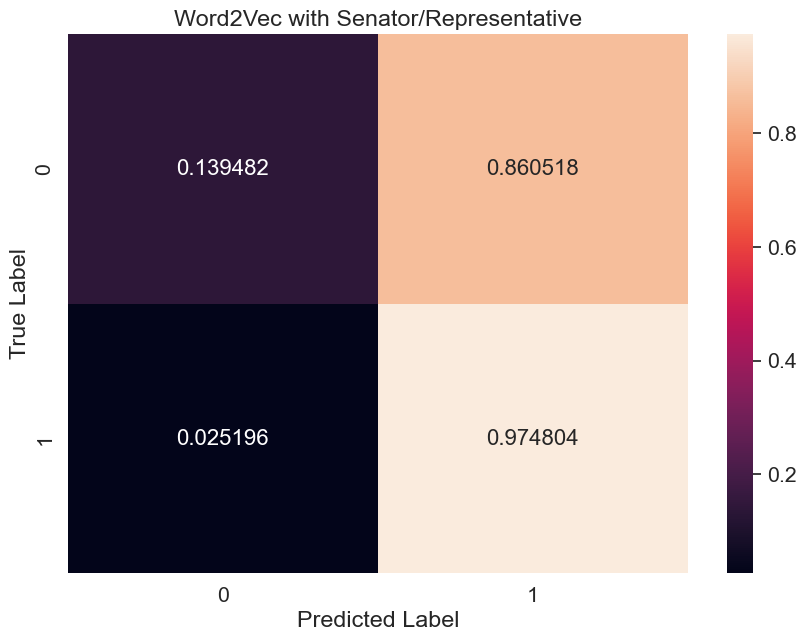

In [127]:
logisticRegressionBatch(dataframes, techniques,targets,target_labels, target_cat_labels)

### Two Combined Models

In [151]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])

# tweets.head()
nontext_features = tweets.select(["trump_2016_state_share", "clinton_2016_state_share","obama_2012_state_share","romney_2012_state_share"])\
    .with_columns(
        trump_2016_state_share=pl.col('trump_2016_state_share').map_elements(lambda x: locale.atoi(x), return_dtype=pl.Int64),
        clinton_2016_state_share=pl.col('clinton_2016_state_share').map_elements(lambda x: locale.atoi(x), return_dtype=pl.Int64),
        obama_2012_state_share=pl.col('obama_2012_state_share').map_elements(lambda x: locale.atoi(x), return_dtype=pl.Int64),
        romney_2012_state_share=pl.col('romney_2012_state_share').map_elements(lambda x: locale.atoi(x), return_dtype=pl.Int64)
        )
best_combined = numpy.concatenate((nontext_features,doc_embeddings), axis=1)


In [152]:
nontext_features.head()

trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
i64,i64,i64,i64
1318255,729547,795696,1255925
1318255,729547,795696,1255925
1318255,729547,795696,1255925
1318255,729547,795696,1255925
1318255,729547,795696,1255925


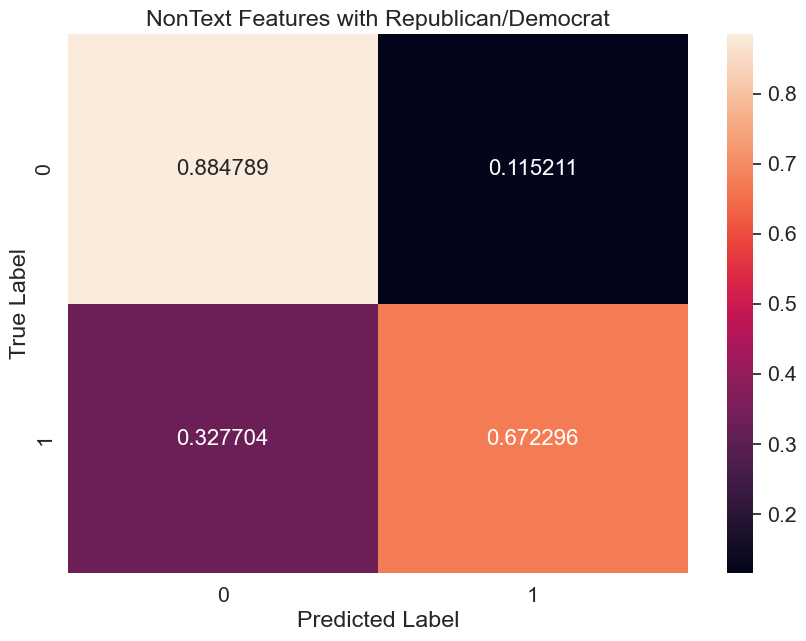

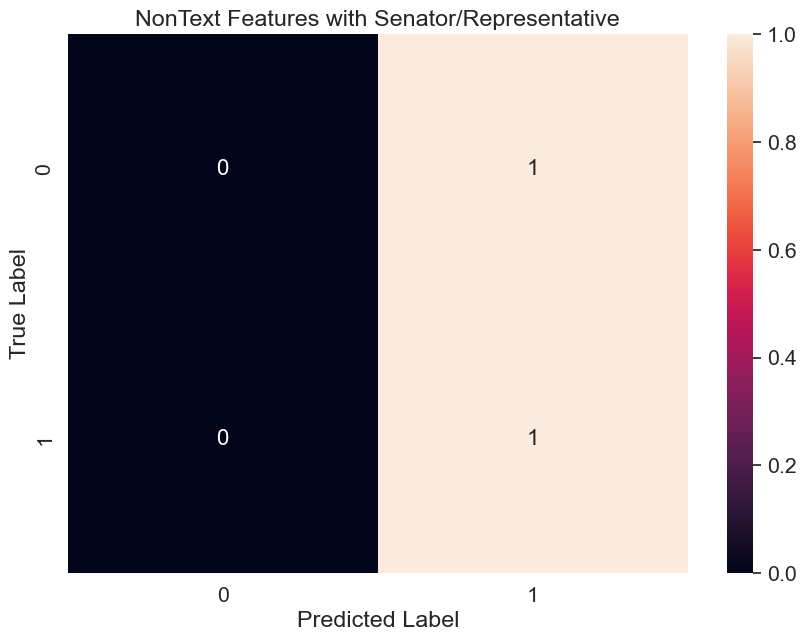

/Users/erawn/Computational-Social-Science-Training-Program/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


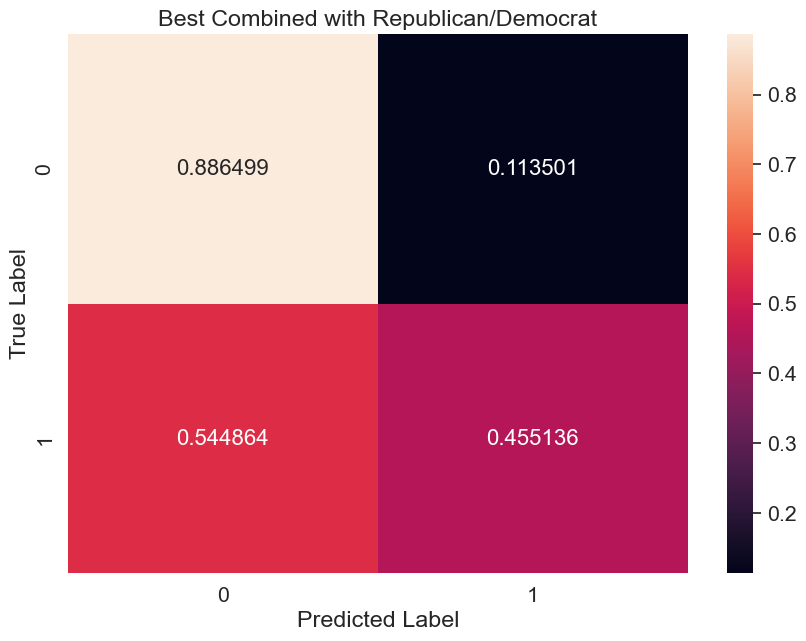

/Users/erawn/Computational-Social-Science-Training-Program/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


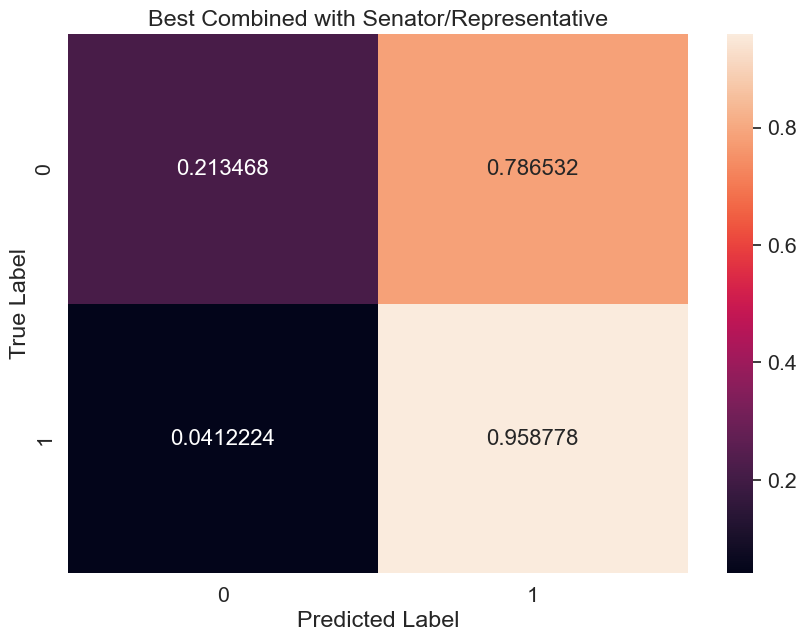

In [153]:
logisticRegressionBatch([nontext_features,best_combined], ["NonText Features", "Best Combined"],targets,target_labels, target_cat_labels)

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Particular corpi have unique features that are contextual. For this corpus, we're dealing with tweets, so inclusions like "amp, RT, QT" might not be helpful for text processing (although we could extract another feature from it, if we think Republicans retweet at a higher rate than Democrats, for example). Additionally, we need to figure out what constitutes a document for each corpus -- in this case, we're dealing with tweets as our individual document unit, but depending on our corpus and our analysis choices, we could have decided this differently (a thread, for instance).

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

There did seem to be some prediction ability to distinguish Democrats and Republicans, but very little from Senators and Representatives. Based on one of the exploratory analyses (the scatterplot), I had expected that we would have seen some prediction on polarity (democrats seemed to have greater positive polarity compared to democrats), but I couldn't see this on the logistic regression, so that remains to be seen. 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

As I talked about above, I had seen in the exploratory analysis a trend (that democrats seem to have more positive polarity tweets on the whole) that also supported a theory I find personally pretty believable (that democrats have more positive, on average, content on twitter, or use more positive words for that matter), but this wasn't shown out in the logistic regression. That isn't to say the relationship isn't there, but without showing how the polarity would predict the party, the exploratory analysis should be left at that, exploration. 

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

Perhaps unexpectedly, non-text did the best on predicting party (vote share is a pretty good predictor of political party, it turns out), but the combined did the best for distinguishing senator/representative. The intuition behind why that might be the best is that the best way to predict senator/representative might be a combination of the multiple variables. So perhaps content alone does an ok-job predicting, but combined with other non-text features, specific content embeddings with other data might outperform. We can think about non-text features as adding additional context to the text-data. Perhaps, for example, Republicans and Democrats use different language based on if they live in a swing state (sounds plausible to me at least), which a logistic regression could pick up on as a linear combination of the variables. 